# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [371]:
ans_1 = 17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [372]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from time import perf_counter
import seaborn as sns
import matplotlib.pyplot as plt

#### Dataset Citation
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001

In [373]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [374]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Answer 3
Let's look at the columns that are categorical to determine how to treat them. To start, document how many total rows exist in the dataset.

In [375]:
print(f'Total rows: {df.shape[0]}')

Total rows: 41188


Next, let's look at the categorical data to see what values we are dealing with.

Note: I know it's in the markdown cell above but I still like to see it in the dataset.

In [376]:
features_to_check = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for col in features_to_check:
    print(f"{col} → {df[col].unique()}\n")

job → ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

marital → ['married' 'single' 'divorced' 'unknown']

education → ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

default → ['no' 'unknown' 'yes']

housing → ['no' 'yes' 'unknown']

loan → ['no' 'yes' 'unknown']

contact → ['telephone' 'cellular']

month → ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week → ['mon' 'tue' 'wed' 'thu' 'fri']

poutcome → ['nonexistent' 'failure' 'success']



We see the following missing data representations:
* job, marital, education, default, housing, and loan - All have 'unknown' values.
* contact, month, day_of_week - Unique values imply no missing data. We will check.
* poutcome - Has 'nonexistent' value.

Next check the counts of missing values in categorical columns.

In [377]:
unknown_counts = df[['job', 'marital', 'education', 'default', 'housing', 'loan']].apply(lambda x: (x == 'unknown').sum())
print(unknown_counts)

job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64


In [378]:
features = ['contact', 'month', 'day_of_week']

missing_check = df[features].isnull().sum()
print("Missing values:\n", missing_check)

print("\nUnique values:")
for col in features:
    print(f"{col}: {df[col].unique()}\n")

Missing values:
 contact        0
month          0
day_of_week    0
dtype: int64

Unique values:
contact: ['telephone' 'cellular']

month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']



In [379]:
unknown_counts = df[['poutcome']].apply(lambda x: (x == 'nonexistent').sum())
print(unknown_counts)

poutcome    35563
dtype: int64


#### Categorical feature summary
Generally, we will one-hot encode these features with the following caviots.

* job, marital - Impute 'unknown' using mode.
* education, default, housing, loan - Preserve 'unknown' due to larger number of rows containing the value in these features.
* contact, month, day_of_week - No missing values.
* poutcome - Assuming 'nonexistent' means no previous marketing campaign. Keeping 'nonexistent'. 

Let's look at the numeric features. 

Note: pdays has a numeric value of 999 when a customer hasn't been previously contacted. 

In [380]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [381]:
for col in numeric_cols:
    print(f"{col}:")
    print(f"  Missing: {df[col].isnull().sum()}")
    print(f"  Non-numeric: {(~df[col].apply(lambda x: isinstance(x, (int, float)))).sum()}")

age:
  Missing: 0
  Non-numeric: 0
duration:
  Missing: 0
  Non-numeric: 0
campaign:
  Missing: 0
  Non-numeric: 0
pdays:
  Missing: 0
  Non-numeric: 0
previous:
  Missing: 0
  Non-numeric: 0
emp.var.rate:
  Missing: 0
  Non-numeric: 0
cons.price.idx:
  Missing: 0
  Non-numeric: 0
cons.conf.idx:
  Missing: 0
  Non-numeric: 0
euribor3m:
  Missing: 0
  Non-numeric: 0
nr.employed:
  Missing: 0
  Non-numeric: 0


In [382]:
##### Look at numeric feature correlation

y_num             1.000000
duration          0.405274
previous          0.230181
cons.conf.idx     0.054878
age               0.030399
campaign         -0.066357
cons.price.idx   -0.136211
emp.var.rate     -0.298334
euribor3m        -0.307771
pdays            -0.324914
nr.employed      -0.354678
Name: y_num, dtype: float64


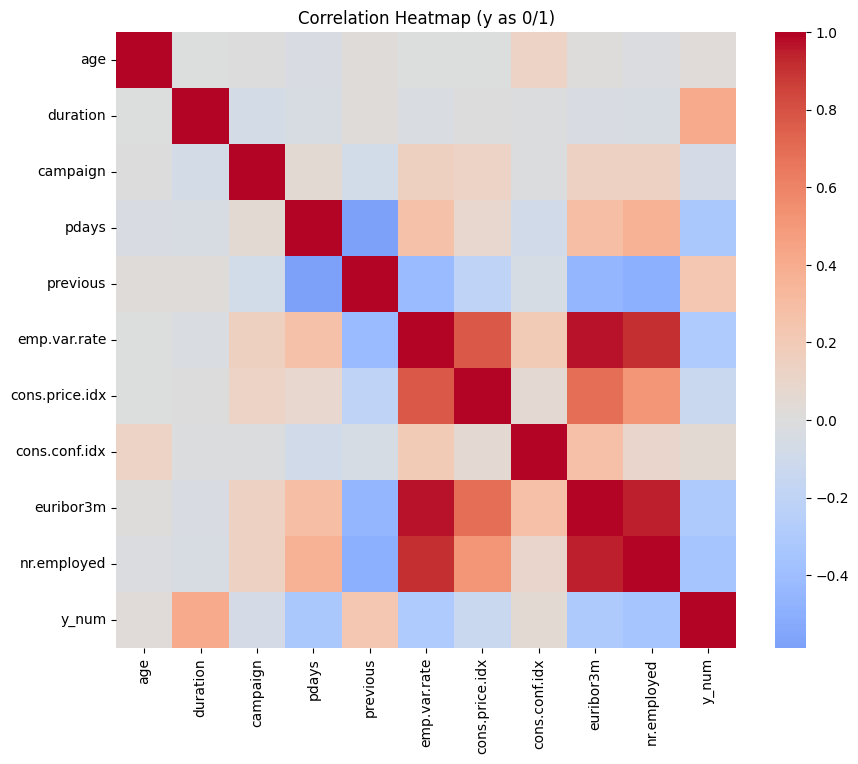

In [383]:
y_num = df['y'].map({'no': 0, 'yes': 1}).astype(int)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_df = df[num_cols].copy()
corr_df['y_num'] = y_num

corr_matrix = corr_df.corr()

print(corr_matrix['y_num'].sort_values(ascending=False))

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap (y as 0/1)')
plt.show()

##### The Duration Feature
Since duration is not known before a call, it can't be used to predict something that we don't know yet. We will remove this feature.

##### The macro-economic features
Potentially strong signals from emp.var.rate, euribor3m, and nr.employed.

#### Numeric feature summary
No missing values. No coersion is necessary. Remove duration.

#### Output variable
Check the values are all 'yes' or 'no' with no values missing.

In [384]:
unique_values = set(df['y'].dropna().unique())
print(f"Unique values: {unique_values}")

missing_count = df['y'].isna().sum()
print(f"Missing values in 'y': {missing_count}")

Unique values: {'yes', 'no'}
Missing values in 'y': 0


#### Output variable summary
No missing or unexpected values. Encode output variable as a 0 or 1. 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Answer 4

Per the research paper the goal of the study was:

    "The business goal is to find a model that can explain success of a contact, i.e. if the client subscribes the deposit."
    
By accurately identifying clients, the bank can:

* improve campaign targeting
* increate subscription rates

Additionally, the stated objective of this practical application is: 

    "To compare the performance of the classifiers (k-nearest neighbors, logistic regression, decision trees, and support vector machines)."machines)."

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### Answer 5 - Select the 'bank client data' features. 
I'm not sure if that is what is meant by bank information features, but that is what we are starting with.


In [386]:
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
X = df[bank_features].copy()
y = df['y'].map({'no': 0, 'yes': 1}).astype('int8')

##### Preprocessing
We use scaling for numeric features so that one numeric feature doesn't dominate other numeric features of different (smaller) scales.

In [387]:
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features), # handle_unknown='ignore'
    ]
)

##### Model Pipeline
Build a pipeline.

In [388]:
clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(
        solver='lbfgs', max_iter=1000, class_weight='balanced', random_state=42
    ))
])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [389]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

##### Baseline Accuracy
We would select the majority class where there are imbalanced classes.

In [390]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

Baseline accuracy: 0.8873


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [391]:
clf.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Problem 9: Score the Model

What is the accuracy of your model?

In [392]:
y_pred = clf.predict(X_test)

baseline = y_train.value_counts(normalize=True).max()
acc = accuracy_score(y_test, y_pred)

print(f"Baseline (majority class) accuracy: {baseline:.4f}")
print(f"Logistic Regression accuracy:       {acc:.4f}")

Baseline (majority class) accuracy: 0.8873
Logistic Regression accuracy:       0.5844


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [393]:
# bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
# X = df[bank_features].copy()
# y = df['y'].map({'no': 0, 'yes': 1}).astype('int8')

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# numeric_features = ['age']
# categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features), # handle_unknown='ignore', sparse_output=False
    ]
)

In [394]:
models = {
    'Logistic Regression': LogisticRegression(),      # default settings
    'KNN': KNeighborsClassifier(),                    # default settings
    'Decision Tree': DecisionTreeClassifier(),        # default settings
    'SVM (RBF)': SVC(),                               # default settings
}

results = []

results.append({
        'Model': "Baseline",
        'Train Time': 0,
        'Train Accuracy': 0,
        'Test Accuracy': y_train.value_counts(normalize=True).max()
    })

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    t0 = perf_counter()
    pipe.fit(X_train, y_train)
    train_time = perf_counter() - t0

    train_acc = pipe.score(X_train, y_train)
    test_acc  = pipe.score(X_test, y_test)

    results.append({
        'Model': name,
        'Train Time': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
    })

df_results = pd.DataFrame(results)

# Clean formatting and column order
df_results = (df_results
              .assign(**{
                  'Train Time': df_results['Train Time'].round(3),
                  'Train Accuracy': df_results['Train Accuracy'].round(4),
                  'Test Accuracy': df_results['Test Accuracy'].round(4)
              })
              .loc[:, ['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy']]
)

df_results.sort_values('Test Accuracy', ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results


,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.046,0.8873,0.8874
1,Baseline,0.000,0.0000,0.8873
2,SVM (RBF),35.741,0.8882,0.8864
3,KNN,0.022,0.8897,0.8774
4,Decision Tree,0.367,0.9171,0.8656


### Problem 11: Improving the Model
Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Answer 11 - Gender
If we had gender, we could check if gender correlates to y. If the outcome is largely the same, gender might not play much of a role.

Even if gender improves the metrics, there are considerations to including it.
* It could be a fairness issue if it leads to discriminatory outcomes.
* It could erode trust if it is seen as treating one gender differently.

#### Answer 11 - Hyperparameter tuning and grid search

In [395]:
# Same lists as before
numeric_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ],
    remainder='drop'
)


In [396]:
pipe_knn = Pipeline([('prep', preprocess), ('clf', KNeighborsClassifier())])
pipe_dt  = Pipeline([('prep', preprocess), ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

In [397]:
grid_knn = {
    'clf__n_neighbors': [5, 11, 21, 31]
}

grid_dt = {
    'clf__max_depth': [3, 5, 8, 12, None]
}

In [398]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'avg_prec': 'average_precision'
}

def run_grid(name, pipe, grid, X_train, y_train):
    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=scoring,
        refit='roc_auc',
        cv=5,
        n_jobs=1,
        verbose=1
    )
    search.fit(X_train, y_train)
    print(f"{name} best params:", search.best_params_)
    return name, search

searches = []
searches.append(run_grid('KNN', pipe_knn, grid_knn, X_train, y_train))
searches.append(run_grid('DecisionTree', pipe_dt, grid_dt, X_train, y_train))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
KNN best params: {'clf__n_neighbors': 31}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
DecisionTree best params: {'clf__max_depth': 8}


#### Answer 11 - Performance Metrics

Precision may be an interesting metric. We don't want to be spending a lot of time on false positive leads. Similarly, the recall may be important because missing positives are costly. 

##### Questions